In [6]:
import sys
import os

# Add the parent directory to Python path
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from utils.load_meso_session import MesoscopeSession

import pandas as pd
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.torch import DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import matplotlib.pyplot as plt
from one.api import ONE

# Load the session data
one = ONE()
session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', 0)
activity_matrix, timestamps = session.get_activity_matrix(time_window=300)

Activity matrix shape: (1462, 7673)
Number of neurons: 7673
Number of timepoints: 1462
20th percentile: 0.000, 99th percentile: 221.221
After normalization - Min: 0.000, Max: 1.000
Using 500 most active neurons


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                      | Out sizes   
-----------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | train | [[1, 1], [1, 1], [1, 191, 7], [1, 191], [1, 191], [1, 10, 7]] | [1, 100, 10]
-----------------------------------------------------------------------------------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (

Created dataset with 500 time series
Training DeepAR model...
Epoch 0: |          | 50/? [00:03<00:00, 16.21it/s, v_num=22, train_loss=-6.09]

Epoch 0, global step 50: 'train_loss' reached -6.08684 (best -6.08684), saving model to 'c:\\Users\\Gugu\\Desktop\\UCL\\Thesis\\Experiments\\IBL_Mesoscope\\3_MODELLING\\lightning_logs\\version_22\\checkpoints\\epoch=0-step=50.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: |          | 50/? [00:03<00:00, 16.08it/s, v_num=22, train_loss=-6.09]
Making predictions...
100
2000-01-01 00:01:30    1.0
2000-01-01 00:01:31    1.0
2000-01-01 00:01:32    1.0
2000-01-01 00:01:33    1.0
2000-01-01 00:01:34    0.0
2000-01-01 00:01:35    0.0
2000-01-01 00:01:36    0.0
2000-01-01 00:01:37    0.0
2000-01-01 00:01:38    0.0
2000-01-01 00:01:39    0.0
Freq: s, Name: 2, dtype: float32
100
2000-01-01 00:01:30    0.000000
2000-01-01 00:01:31    0.000000
2000-01-01 00:01:32    0.000000
2000-01-01 00:01:33    0.150379
2000-01-01 00:01:34    0.931845
2000-01-01 00:01:35    0.000000
2000-01-01 00:01:36    0.000000
2000-01-01 00:01:37    0.000000
2000-01-01 00:01:38    0.000000
2000-01-01 00:01:39    0.000000
Freq: s, Name: 4164, dtype: float32
100
2000-01-01 00:01:30    0.00000
2000-01-01 00:01:31    1.00000
2000-01-01 00:01:32    1.00000
2000-01-01 00:01:33    0.00000
2000-01-01 00:01:34    0.00000
2000-01-01 00:01:35    0.94553
2000-01-01 00:01:36    0.00000
2000-01-01

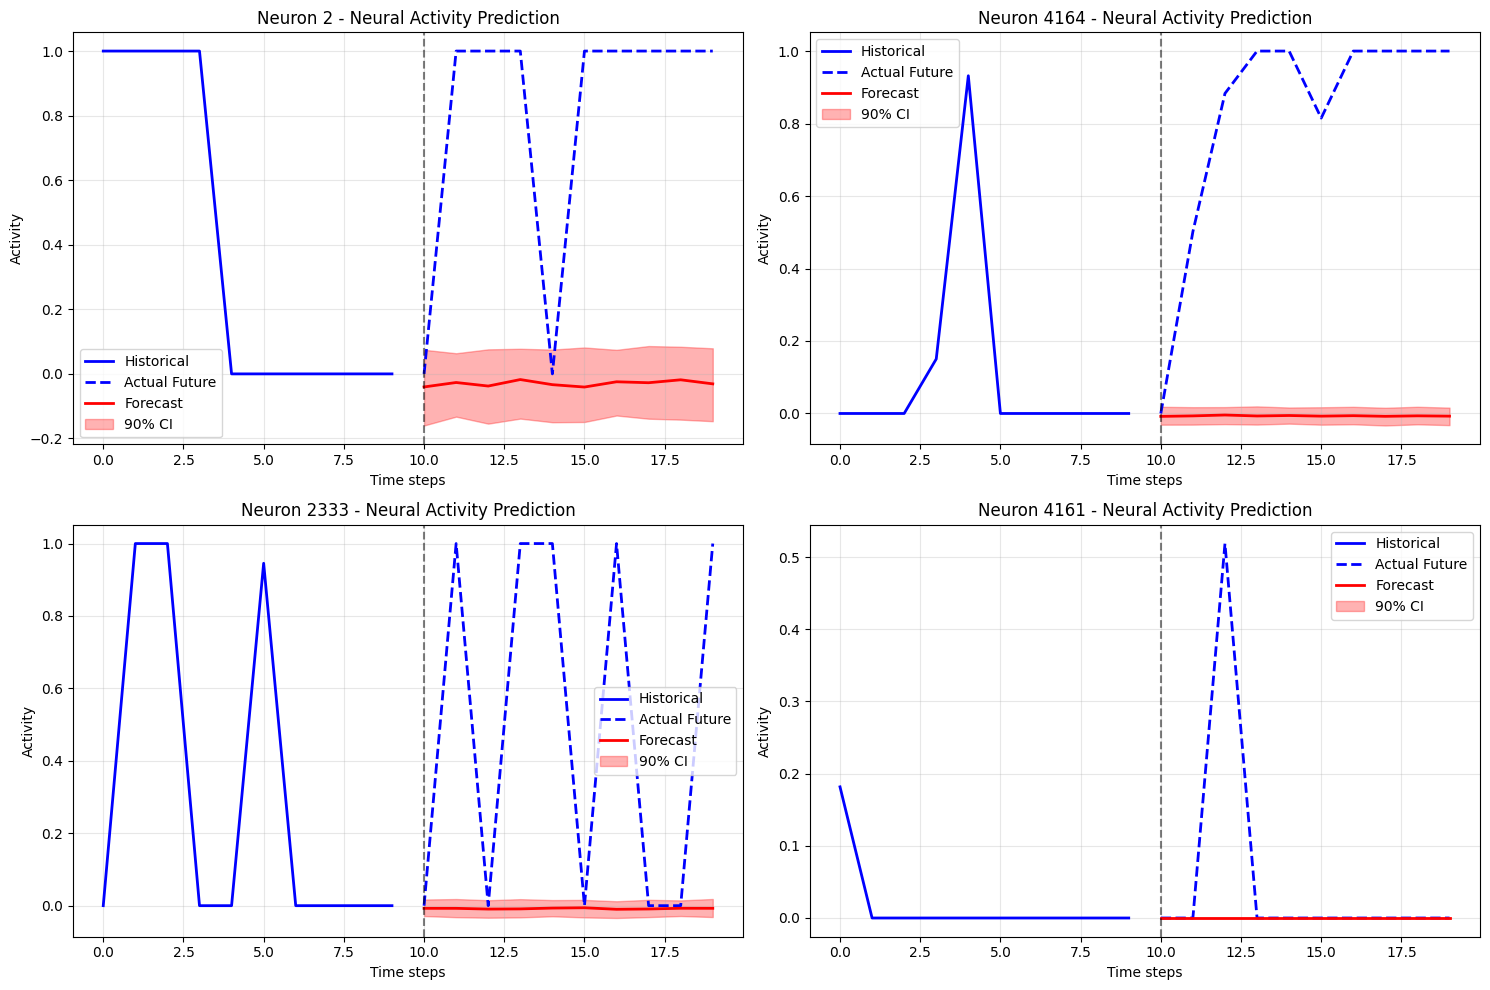

Running evaluation: 500it [00:01, 499.93it/s]
c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)



Evaluation Metrics:
MASE: 1.055
sMAPE: 2.000
MSIS: 38.504

Sample prediction for first neuron:
Predicted next 10 values:
Mean: [-0.0404299  -0.02668355 -0.03765158 -0.01754214 -0.03336208 -0.04074768
 -0.0244249  -0.02736915 -0.01832495 -0.03088676]
Median: [-0.03535675 -0.03662713 -0.03713626 -0.03516713 -0.03548452 -0.03187199
 -0.03117233 -0.0327279  -0.02834366 -0.03329001]


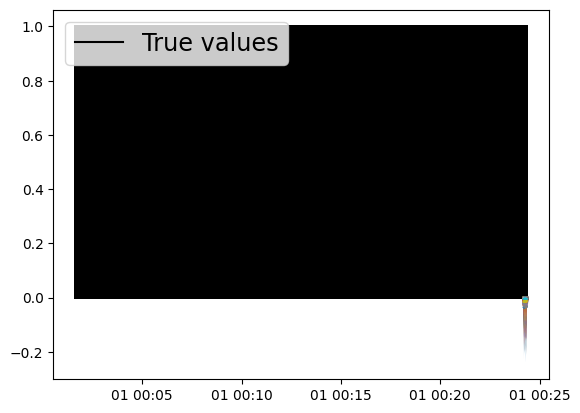

In [24]:
print(f"Activity matrix shape: {activity_matrix.shape}")
print(f"Number of neurons: {activity_matrix.shape[1]}")
print(f"Number of timepoints: {activity_matrix.shape[0]}")

# Convert to pandas DataFrame for GluonTS
df = pd.DataFrame(activity_matrix)
# Create simple 1-second interval timestamps
df.index = pd.date_range(start='2000-01-01', periods=len(df), freq='s')

# Apply percentile-based normalization to the entire matrix
p20 = np.percentile(activity_matrix, 20)
p99 = np.percentile(activity_matrix, 99)
print(f"20th percentile: {p20:.3f}, 99th percentile: {p99:.3f}")

# Normalize: clip values and scale to 0-1
activity_matrix_norm = np.clip(activity_matrix, p20, p99)
activity_matrix_norm = (activity_matrix_norm - p20) / (p99 - p20)

# Update the dataframe with normalized data
df = pd.DataFrame(activity_matrix_norm)
df.index = pd.date_range(start='2000-01-01', periods=len(df), freq='s')

print(f"After normalization - Min: {activity_matrix_norm.min():.3f}, Max: {activity_matrix_norm.max():.3f}")

# Select a subset of neurons for faster training (top 50 most active)
neuron_activity_sums = df.sum(axis=0)
top_neurons = neuron_activity_sums.nlargest(500).index
df_subset = df[top_neurons]

print(f"Using {len(top_neurons)} most active neurons")

# Create GluonTS dataset using pandas Series directly
# We'll treat each neuron as a separate time series
dataset_series = []
for neuron_id in df_subset.columns:
    ts_data = df_subset[neuron_id].dropna()
    if len(ts_data) > 100:  # Only include neurons with enough data
        dataset_series.append(ts_data)

print(f"Created dataset with {len(dataset_series)} time series")

# Convert to GluonTS dataset - pass the pandas Series directly
dataset = PandasDataset(dataset_series, freq='s')  # 1 second frequency

# Split into train/test
prediction_length = 10  # Predict next 10 time steps
num_test_windows = 3

# Create estimator
estimator = DeepAREstimator(
    freq='s',
    prediction_length=prediction_length,
    num_layers=2,
    hidden_size=40,
    dropout_rate=0.1,
    batch_size=32,
    num_batches_per_epoch=50,
    trainer_kwargs={'max_epochs': 1}
)

# Train the model
print("Training DeepAR model...")
predictor = estimator.train(dataset)

# Make predictions
print("Making predictions...")
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=1000
)

# Collect forecasts and actual values
forecasts = list(forecast_it)
tss = list(ts_it)

# Plot results for the first few neurons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(4, len(forecasts))):
    ax = axes[i]
    
    # Get the time series and forecast
    ts_test = tss[i]  # This is the test portion (what we're trying to predict)
    forecast = forecasts[i]
    
    # Get the full original time series to show context
    full_ts = dataset_series[i]  # Original full series
    
    # Show 10 points before prediction and 10 points after
    window_before = 10
    window_after = 10
    
    # Find where the test period starts in the full series
    test_start = 100 #len(full_ts) - len(ts_test)
    print(test_start)
    # Historical data - 10 points before test period
    historical_data = full_ts[test_start-window_before:test_start]
    historical_range = range(len(historical_data))
    print(historical_data)
    ax.plot(historical_range, historical_data, color='blue', label='Historical', linewidth=2)
    
    # Actual future values (what we're trying to predict)
    actual_future = ts_test[:window_after]
    actual_range = range(len(historical_data), len(historical_data) + len(actual_future))
    ax.plot(actual_range, actual_future, color='blue', label='Actual Future', linewidth=2, linestyle='--')
    
    # Forecast
    forecast_mean = forecast.mean[:window_after]
    forecast_range = range(len(historical_data), len(historical_data) + len(forecast_mean))
    ax.plot(forecast_range, forecast_mean, color='red', label='Forecast', linewidth=2)
    
    # Plot confidence intervals manually
    # try:
    forecast_lower = forecast.quantile(0.1)[:window_after]
    forecast_upper = forecast.quantile(0.9)[:window_after]
    ax.fill_between(forecast_range, forecast_lower, forecast_upper, 
                    color='red', alpha=0.3, label='90% CI')
    # except:
    #     print(f"Could not plot confidence intervals for neuron {i}")
    
    ax.set_title(f'Neuron {top_neurons[i]} - Neural Activity Prediction')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Activity')
    ax.axvline(x=len(historical_data), color='black', linestyle='--', alpha=0.5, label='Prediction start')

plt.tight_layout()
plt.show()

# Evaluate the model
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

print("\nEvaluation Metrics:")
print(f"MASE: {agg_metrics['MASE']:.3f}")
print(f"sMAPE: {agg_metrics['sMAPE']:.3f}")
print(f"MSIS: {agg_metrics['MSIS']:.3f}")

# Show sample prediction
print(f"\nSample prediction for first neuron:")
sample_forecast = forecasts[0]
print(f"Predicted next {prediction_length} values:")
print(f"Mean: {sample_forecast.mean}")
print(f"Median: {sample_forecast.quantile(0.5)}")

# Plot predictions
plt.plot(df["2000-01-01 00:01:39":], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")
plt.show()

In [25]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

AttributeError: 'PandasDataset' object has no attribute 'test'

Activity matrix shape: (1462, 7673)
Number of neurons: 7673
Number of timepoints: 1462
20th percentile: 0.000, 99th percentile: 221.221
After normalization - Min: 0.000, Max: 1.000
Using 2000 most active neurons


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | In sizes                                                      | Out sizes   
-----------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | train | [[1, 1], [1, 1], [1, 191, 7], [1, 191], [1, 191], [1, 10, 7]] | [1, 100, 10]
-----------------------------------------------------------------------------------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (

Created dataset with 2000 time series
Training DeepAR model...
Epoch 0: |          | 50/? [00:03<00:00, 15.87it/s, v_num=30, train_loss=-6.20]

Epoch 0, global step 50: 'train_loss' reached -6.20453 (best -6.20453), saving model to 'c:\\Users\\Gugu\\Desktop\\UCL\\Thesis\\Experiments\\IBL_Mesoscope\\3_MODELLING\\lightning_logs\\version_30\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:03<00:00, 15.77it/s, v_num=30, train_loss=-7.57]

Epoch 1, global step 100: 'train_loss' reached -7.57081 (best -7.57081), saving model to 'c:\\Users\\Gugu\\Desktop\\UCL\\Thesis\\Experiments\\IBL_Mesoscope\\3_MODELLING\\lightning_logs\\version_30\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:03<00:00, 16.36it/s, v_num=30, train_loss=-7.92]

Epoch 2, global step 150: 'train_loss' reached -7.92219 (best -7.92219), saving model to 'c:\\Users\\Gugu\\Desktop\\UCL\\Thesis\\Experiments\\IBL_Mesoscope\\3_MODELLING\\lightning_logs\\version_30\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:02<00:00, 17.09it/s, v_num=30, train_loss=-7.47]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: |          | 50/? [00:03<00:00, 16.58it/s, v_num=30, train_loss=-8.19]

Epoch 4, global step 250: 'train_loss' reached -8.18696 (best -8.18696), saving model to 'c:\\Users\\Gugu\\Desktop\\UCL\\Thesis\\Experiments\\IBL_Mesoscope\\3_MODELLING\\lightning_logs\\version_30\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:03<00:00, 16.51it/s, v_num=30, train_loss=-8.22]

Epoch 5, global step 300: 'train_loss' reached -8.22480 (best -8.22480), saving model to 'c:\\Users\\Gugu\\Desktop\\UCL\\Thesis\\Experiments\\IBL_Mesoscope\\3_MODELLING\\lightning_logs\\version_30\\checkpoints\\epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:02<00:00, 17.24it/s, v_num=30, train_loss=-8.29]

Epoch 6, global step 350: 'train_loss' reached -8.28585 (best -8.28585), saving model to 'c:\\Users\\Gugu\\Desktop\\UCL\\Thesis\\Experiments\\IBL_Mesoscope\\3_MODELLING\\lightning_logs\\version_30\\checkpoints\\epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:03<00:00, 16.16it/s, v_num=30, train_loss=-7.54]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |          | 50/? [00:02<00:00, 17.06it/s, v_num=30, train_loss=-7.58]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:02<00:00, 16.87it/s, v_num=30, train_loss=-7.54]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:03<00:00, 16.04it/s, v_num=30, train_loss=-7.80]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [00:03<00:00, 14.96it/s, v_num=30, train_loss=-8.00]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:03<00:00, 16.40it/s, v_num=30, train_loss=-8.37]

Epoch 12, global step 650: 'train_loss' reached -8.36632 (best -8.36632), saving model to 'c:\\Users\\Gugu\\Desktop\\UCL\\Thesis\\Experiments\\IBL_Mesoscope\\3_MODELLING\\lightning_logs\\version_30\\checkpoints\\epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:03<00:00, 16.54it/s, v_num=30, train_loss=-8.31]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:03<00:00, 16.56it/s, v_num=30, train_loss=-7.46]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:03<00:00, 16.18it/s, v_num=30, train_loss=-7.87]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:03<00:00, 16.57it/s, v_num=30, train_loss=-7.68]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:02<00:00, 17.06it/s, v_num=30, train_loss=-7.74]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:03<00:00, 16.45it/s, v_num=30, train_loss=-7.96]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:02<00:00, 16.96it/s, v_num=30, train_loss=-7.42]

Epoch 19, global step 1000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: |          | 50/? [00:02<00:00, 16.93it/s, v_num=30, train_loss=-7.42]
Making predictions...


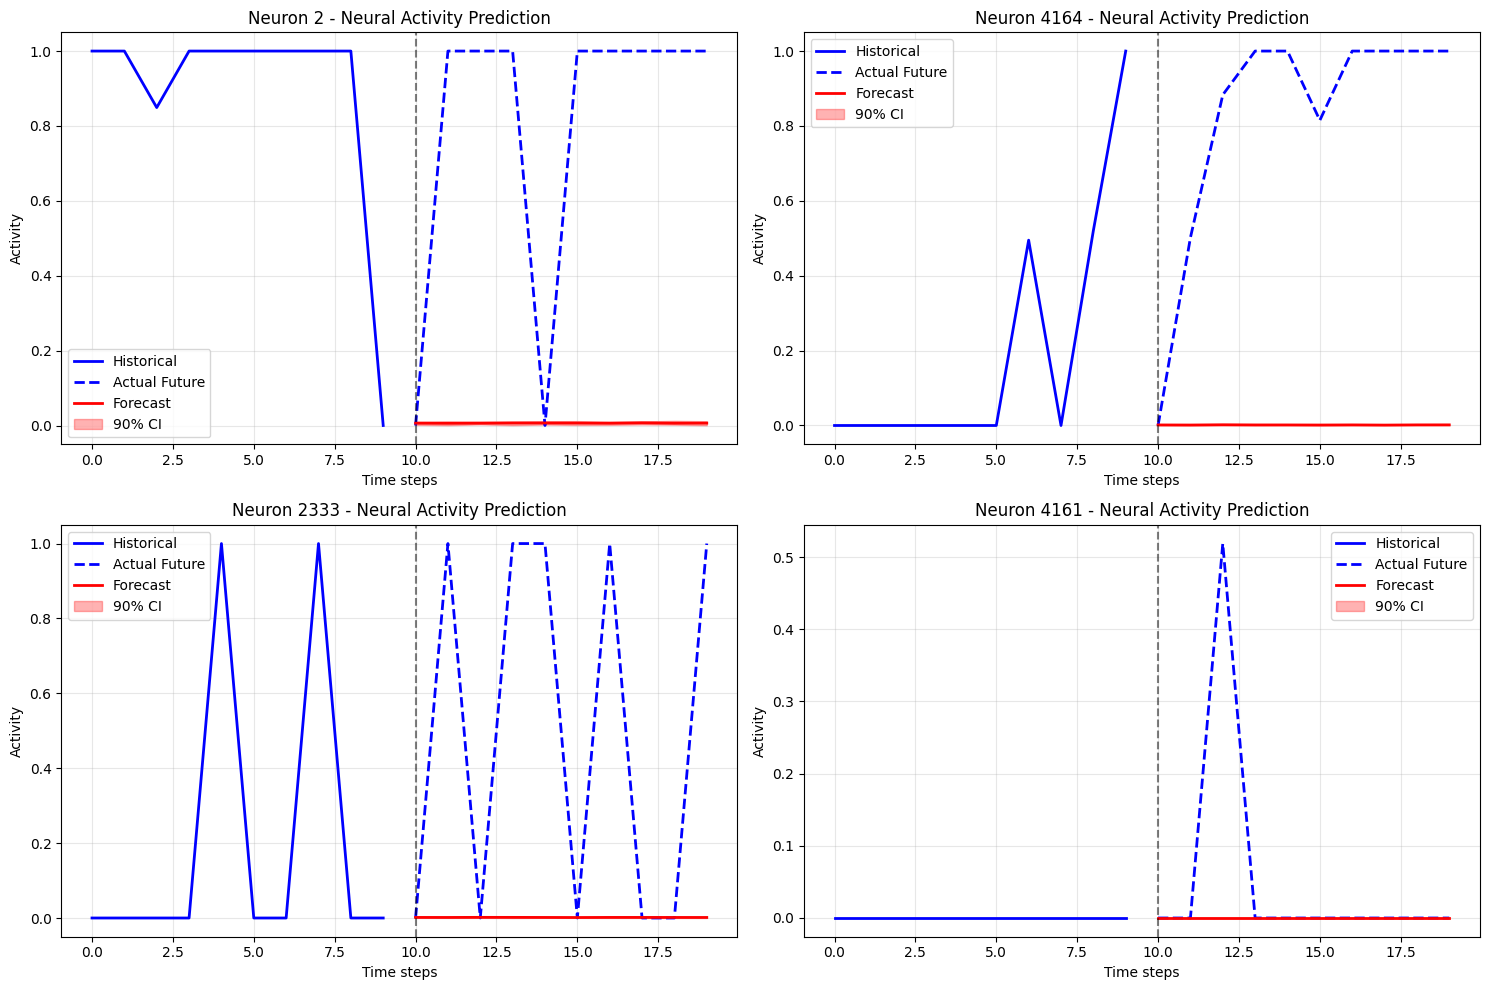

Running evaluation: 2000it [00:03, 542.00it/s]


Evaluation Metrics:
MASE: 0.883
sMAPE: 1.996
MSIS: 34.971

Sample prediction for first neuron:
Predicted next 10 values:
Mean: [0.00624248 0.00588138 0.00624581 0.00658752 0.00669351 0.00652119
 0.00611817 0.00721628 0.00610753 0.00634212]
Median: [0.00615178 0.00675859 0.00730431 0.00683778 0.00676325 0.00677355
 0.00646251 0.00744694 0.00686548 0.00675876]



c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [33]:
print(f"Activity matrix shape: {activity_matrix.shape}")
print(f"Number of neurons: {activity_matrix.shape[1]}")
print(f"Number of timepoints: {activity_matrix.shape[0]}")

# Convert to pandas DataFrame for GluonTS
df = pd.DataFrame(activity_matrix)
# Create simple 1-second interval timestamps
df.index = pd.date_range(start='2000-01-01', periods=len(df), freq='s')

# Apply percentile-based normalization to the entire matrix
p20 = np.percentile(activity_matrix, 20)
p99 = np.percentile(activity_matrix, 99)
print(f"20th percentile: {p20:.3f}, 99th percentile: {p99:.3f}")

# Normalize: clip values and scale to 0-1
activity_matrix_norm = np.clip(activity_matrix, p20, p99)
activity_matrix_norm = (activity_matrix_norm - p20) / (p99 - p20)

# Update the dataframe with normalized data
df = pd.DataFrame(activity_matrix_norm)
df.index = pd.date_range(start='2000-01-01', periods=len(df), freq='s')

print(f"After normalization - Min: {activity_matrix_norm.min():.3f}, Max: {activity_matrix_norm.max():.3f}")

# Select a subset of neurons for faster training (top 50 most active)
neuron_activity_sums = df.sum(axis=0)
top_neurons = neuron_activity_sums.nlargest(2000).index
df_subset = df[top_neurons]

print(f"Using {len(top_neurons)} most active neurons")

# Create GluonTS dataset using pandas Series directly
# We'll treat each neuron as a separate time series
dataset_series = []
for neuron_id in df_subset.columns:
    ts_data = df_subset[neuron_id].dropna()
    if len(ts_data) > 100:  # Only include neurons with enough data
        dataset_series.append(ts_data)

print(f"Created dataset with {len(dataset_series)} time series")

# Convert to GluonTS dataset - pass the pandas Series directly
dataset = PandasDataset(dataset_series, freq='s')  # 1 second frequency

# Split into train/test
prediction_length = 10  # Predict next 10 time steps
num_test_windows = 3

# Create estimator
estimator = DeepAREstimator(
    freq='s',
    prediction_length=prediction_length,
    num_layers=2,
    hidden_size=40,
    dropout_rate=0.1,
    batch_size=32,
    num_batches_per_epoch=50,
    trainer_kwargs={'max_epochs': 20}
)

# Train the model
print("Training DeepAR model...")
predictor = estimator.train(dataset)

# Make predictions
print("Making predictions...")
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)

# Collect forecasts and actual values
forecasts = list(forecast_it)
tss = list(ts_it)  # These are the actual future values (test targets)

# Plot results for the first few neurons
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(4, len(forecasts))):
    ax = axes[i]
    
    # Get the actual test values and forecast
    actual_future = tss[i]  # These are the actual values we're trying to predict
    forecast = forecasts[i]
    
    # Get some historical context from the original series
    full_ts = dataset_series[i]
    
    # Show just the last 10 historical points and first 10 prediction points
    context_points = 10
    
    # Historical context - last 10 points before prediction starts
    historical_data = full_ts[-prediction_length-context_points:-prediction_length]
    historical_range = range(context_points)
    ax.plot(historical_range, historical_data, color='blue', label='Historical', linewidth=2)
    
    # Actual future values (first 10 of the prediction period)
    actual_future_subset = actual_future[:context_points]
    actual_range = range(context_points, context_points * 2)
    ax.plot(actual_range, actual_future_subset, color='blue', label='Actual Future', linewidth=2, linestyle='--')
    
    # Forecast (first 10 prediction points)
    forecast_mean = forecast.mean[:context_points]
    forecast_range = range(context_points, context_points * 2)
    ax.plot(forecast_range, forecast_mean, color='red', label='Forecast', linewidth=2)
    
    # Plot confidence intervals
    try:
        forecast_lower = forecast.quantile(0.1)[:context_points]
        forecast_upper = forecast.quantile(0.9)[:context_points]
        ax.fill_between(forecast_range, forecast_lower, forecast_upper, 
                       color='red', alpha=0.3, label='90% CI')
    except:
        print(f"Could not plot confidence intervals for neuron {i}")
    
    ax.set_title(f'Neuron {top_neurons[i]} - Neural Activity Prediction')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Activity')
    ax.axvline(x=context_points, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Evaluate the model
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts))

print("\nEvaluation Metrics:")
print(f"MASE: {agg_metrics['MASE']:.3f}")
print(f"sMAPE: {agg_metrics['sMAPE']:.3f}")
print(f"MSIS: {agg_metrics['MSIS']:.3f}")

# Show sample prediction
print(f"\nSample prediction for first neuron:")
sample_forecast = forecasts[0]
print(f"Predicted next {prediction_length} values:")
print(f"Mean: {sample_forecast.mean}")
print(f"Median: {sample_forecast.quantile(0.5)}")

Activity matrix shape: (1462, 7673)
Number of neurons: 7673
Number of timepoints: 1462
20th percentile: 0.000, 99th percentile: 221.221
After log transform - Min: 0.000, Max: 0.693
Category distribution: [9692168  503500  503500  518758]
Percentages: [86.39892971  4.48835195  4.48835195  4.62436639]
Creating cross-neuron prediction dataset...
Dataset shape: (73000, 501)
Target distribution: [57330  1140  1548 12982]
Number of target neurons: 50
Number of context neurons: 500
Training set: 58400 samples
Test set: 14600 samples

Training Random Forest...
Random Forest Accuracy: 0.784
Classification Report:
              precision    recall  f1-score   support

    Inactive       0.79      0.99      0.88     11466
         Low       0.00      0.00      0.00       228
      Medium       0.00      0.00      0.00       310
        High       0.43      0.02      0.04      2596

    accuracy                           0.78     14600
   macro avg       0.30      0.25      0.23     14600
weighted

c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Logistic Regression Accuracy: 0.780
Classification Report:
              precision    recall  f1-score   support

    Inactive       0.80      0.97      0.87     11466
         Low       0.00      0.00      0.00       228
      Medium       0.00      0.00      0.00       310
        High       0.43      0.12      0.19      2596

    accuracy                           0.78     14600
   macro avg       0.31      0.27      0.27     14600
weighted avg       0.70      0.78      0.72     14600


Best model: Random Forest with accuracy 0.784


c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gugu\Desktop\UCL\Thesis\Experiments\IBL_Mesoscope\ibl_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

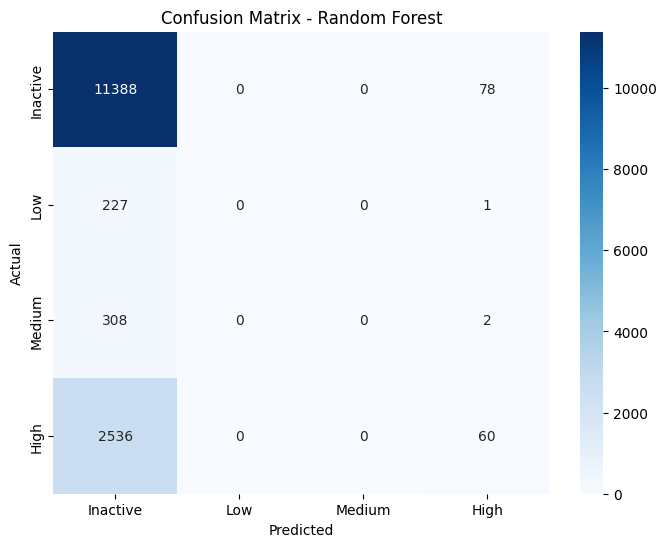

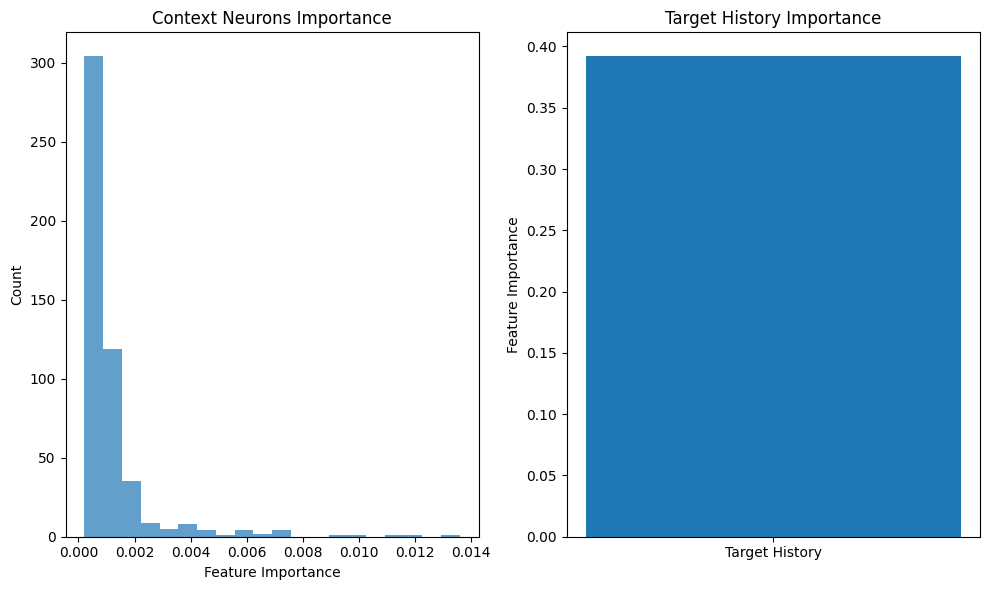

Target history importance: 0.392
Mean context importance: 0.001
Max context importance: 0.014

Example predictions:
Neuron 6358: Actual=0, Predicted=0, ✓
Neuron 2329: Actual=0, Predicted=0, ✓
Neuron 45: Actual=0, Predicted=0, ✓
Neuron 18: Actual=0, Predicted=0, ✓
Neuron 5232: Actual=0, Predicted=0, ✓

Performance by activity category:
Inactive: 0.993 (11466 samples)
Low: 0.000 (228 samples)
Medium: 0.000 (310 samples)
High: 0.023 (2596 samples)


In [37]:
# Cross-neuron conditional prediction approach
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from one.api import ONE

# Load the session data
one = ONE()
session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', 0)
activity_matrix, timestamps = session.get_activity_matrix(time_window=300)

print(f"Activity matrix shape: {activity_matrix.shape}")
print(f"Number of neurons: {activity_matrix.shape[1]}")
print(f"Number of timepoints: {activity_matrix.shape[0]}")

# Apply percentile-based normalization to the entire matrix
p20 = np.percentile(activity_matrix, 20)
p99 = np.percentile(activity_matrix, 99)
print(f"20th percentile: {p20:.3f}, 99th percentile: {p99:.3f}")

# Normalize: clip values and scale to 0-1
activity_matrix_norm = np.clip(activity_matrix, p20, p99)
activity_matrix_norm = (activity_matrix_norm - p20) / (p99 - p20)

# Apply log transformation first, then categorical encoding
activity_matrix_log = np.log1p(activity_matrix_norm)  # log(1 + x) to handle zeros
print(f"After log transform - Min: {activity_matrix_log.min():.3f}, Max: {activity_matrix_log.max():.3f}")

# Create categorical encoding: inactive, low, medium, high (0, 1, 2, 3)
inactive_threshold = 0.001  # Values very close to zero
low_threshold = np.percentile(activity_matrix_log[activity_matrix_log > inactive_threshold], 33)
med_threshold = np.percentile(activity_matrix_log[activity_matrix_log > inactive_threshold], 66)

def categorize_activity(data):
    categories = np.zeros_like(data, dtype=int)
    categories[data <= inactive_threshold] = 0  # inactive
    categories[(data > inactive_threshold) & (data <= low_threshold)] = 1  # low
    categories[(data > low_threshold) & (data <= med_threshold)] = 2  # medium
    categories[data > med_threshold] = 3  # high
    return categories

activity_matrix_categorical = categorize_activity(activity_matrix_log)
print(f"Category distribution: {np.bincount(activity_matrix_categorical.flatten())}")
print(f"Percentages: {np.bincount(activity_matrix_categorical.flatten()) / activity_matrix_categorical.size * 100}")

# Create cross-neuron prediction dataset
def create_cross_neuron_dataset(activity_matrix, target_neurons=100, context_neurons=500):
    """
    Create dataset where we predict target neuron activity from context neurons
    
    For each time step t, predict activity of target neuron at t+1 given:
    - Current activity (t) of all context neurons
    - Previous activity (t-1) of target neuron
    """
    n_timepoints, n_neurons = activity_matrix.shape
    
    # Select most active neurons for prediction
    neuron_activity_sums = np.sum(activity_matrix, axis=0)
    most_active = np.argsort(neuron_activity_sums)[-target_neurons:]
    
    # Select context neurons (exclude target from context)
    available_for_context = np.argsort(neuron_activity_sums)[-(context_neurons + target_neurons):-target_neurons]
    
    X_list = []
    y_list = []
    neuron_ids = []
    
    for target_neuron in most_active:
        # Context: activity of other neurons at time t
        # Target: activity of target neuron at time t+1
        
        for t in range(1, n_timepoints - 1):  # Skip first and last timepoint
            # Features: [context_neurons_at_t, target_neuron_at_t-1]
            context_activity = activity_matrix[t, available_for_context]
            target_prev = activity_matrix[t-1, target_neuron]
            
            features = np.concatenate([context_activity, [target_prev]])
            target_next = activity_matrix[t+1, target_neuron]
            
            X_list.append(features)
            y_list.append(target_next)
            neuron_ids.append(target_neuron)
    
    return np.array(X_list), np.array(y_list), np.array(neuron_ids), most_active, available_for_context

# Create the dataset
print("Creating cross-neuron prediction dataset...")
X, y, neuron_ids, target_neurons, context_neurons = create_cross_neuron_dataset(
    activity_matrix_categorical, 
    target_neurons=50,  # Predict 50 neurons
    context_neurons=500  # Use 500 neurons as context
)

print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Number of target neurons: {len(target_neurons)}")
print(f"Number of context neurons: {len(context_neurons)}")

# Split into train/test
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, neuron_ids, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{model_name} Accuracy: {accuracy:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Inactive', 'Low', 'Medium', 'High']))

# Visualize predictions for best model
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"\nBest model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.3f}")

# Create confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Inactive', 'Low', 'Medium', 'High'],
           yticklabels=['Inactive', 'Low', 'Medium', 'High'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Analyze feature importance (for Random Forest)
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = rf_model.feature_importances_
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    
    # Separate context neurons and target history
    context_importance = feature_importance[:-1]  # All but last feature
    target_history_importance = feature_importance[-1]  # Last feature (target history)
    
    plt.subplot(1, 2, 1)
    plt.hist(context_importance, bins=20, alpha=0.7)
    plt.title('Context Neurons Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.bar(['Target History'], [target_history_importance])
    plt.title('Target History Importance')
    plt.ylabel('Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Target history importance: {target_history_importance:.3f}")
    print(f"Mean context importance: {np.mean(context_importance):.3f}")
    print(f"Max context importance: {np.max(context_importance):.3f}")

# Test on specific examples
print("\nExample predictions:")
for i in range(5):
    idx = np.random.randint(len(X_test))
    actual = y_test[idx]
    predicted = best_predictions[idx]
    neuron_id = ids_test[idx]
    
    print(f"Neuron {neuron_id}: Actual={actual}, Predicted={predicted}, " + 
          f"{'✓' if actual == predicted else '✗'}")

# Performance by category
print("\nPerformance by activity category:")
for category in range(4):
    category_mask = y_test == category
    if np.sum(category_mask) > 0:
        category_accuracy = accuracy_score(y_test[category_mask], best_predictions[category_mask])
        category_name = ['Inactive', 'Low', 'Medium', 'High'][category]
        print(f"{category_name}: {category_accuracy:.3f} ({np.sum(category_mask)} samples)")

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx.model.deepvar import DeepVAREstimator
from gluonts.mx.model.lstnet import LSTNetEstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def create_cross_neuron_prediction_dataset(activity_matrix, context_neurons=50, target_neurons=10):
    """
    Create a dataset where we predict a subset of neurons using others as context.
    
    Args:
        activity_matrix: [time, neurons] matrix
        context_neurons: Number of neurons to use as predictors
        target_neurons: Number of neurons to predict
    
    Returns:
        Multivariate dataset suitable for GluonTS
    """
    print(f"Original matrix shape: {activity_matrix.shape}")
    
    # Select most active neurons for better signal
    neuron_activity_sums = np.sum(activity_matrix, axis=0)
    most_active_indices = np.argsort(neuron_activity_sums)[::-1]
    
    # Select context and target neurons
    total_neurons_needed = context_neurons + target_neurons
    selected_indices = most_active_indices[:total_neurons_needed]
    
    context_indices = selected_indices[:context_neurons]
    target_indices = selected_indices[context_neurons:context_neurons + target_neurons]
    
    print(f"Using {len(context_indices)} context neurons and {len(target_indices)} target neurons")
    
    # Create the multivariate dataset
    # Combine context and target neurons into a single multivariate series
    selected_data = activity_matrix[:, np.concatenate([context_indices, target_indices])]
    
    # Create pandas DataFrame with datetime index
    df = pd.DataFrame(selected_data)
    df.index = pd.date_range(start='2000-01-01', periods=len(df), freq='s')
    
    # Apply normalization to reduce sparsity impact
    df_norm = normalize_sparse_data(df)
    
    return df_norm, context_indices, target_indices

def normalize_sparse_data(df, method='log_transform'):
    """
    Normalize sparse neural data to make it more suitable for neural networks.
    """
    if method == 'log_transform':
        # Add small constant to avoid log(0), then apply log1p
        df_norm = np.log1p(df)
    elif method == 'zscore_robust':
        # Robust z-score using median and MAD
        median = df.median()
        mad = (df - median).abs().median()
        df_norm = (df - median) / (mad + 1e-8)
    elif method == 'percentile_clip':
        # Clip to 95th percentile and normalize
        p95 = df.quantile(0.95)
        df_norm = df.clip(upper=p95.values, axis=1)
        df_norm = df_norm / (p95 + 1e-8)
    else:
        df_norm = df
    
    return df_norm

def train_cross_neuron_predictor(df, context_size, target_size, model_type='deepvar'):
    """
    Train a model to predict target neurons using context neurons.
    
    Args:
        df: Normalized multivariate time series [time, neurons]
        context_size: Number of context neurons
        target_size: Number of target neurons  
        model_type: 'deepvar' or 'lstnet'
    """
    print(f"Training {model_type} model...")
    
    # Create the dataset - GluonTS expects multivariate data as a single series
    dataset = PandasDataset([df], freq='s')
    
    prediction_length = 1  # Predict 1 timestep ahead
    
    if model_type == 'deepvar':
        estimator = DeepVAREstimator(
            freq='s',
            prediction_length=prediction_length,
            target_dim=df.shape[1],  # Total number of neurons (context + target)
            num_layers=2,
            hidden_size=64,
            dropout_rate=0.1,
            batch_size=32,
            num_batches_per_epoch=100,
            trainer_kwargs={'max_epochs': 20}
        )
    elif model_type == 'lstnet':
        estimator = LSTNetEstimator(
            freq='s',
            prediction_length=prediction_length,
            target_dim=df.shape[1],
            num_series=df.shape[1],
            skip_size=24,
            ar_window=24,
            channels=32,
            dropout_rate=0.1,
            output_activation='sigmoid',
            trainer_kwargs={'max_epochs': 20}
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Train the model
    predictor = estimator.train(dataset)
    
    return predictor

def evaluate_cross_predictions(predictor, df, context_size, target_size):
    """
    Evaluate the cross-neuron prediction model.
    """
    print("Evaluating predictions...")
    
    # Create test dataset
    dataset = PandasDataset([df], freq='s')
    
    # Make predictions
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=100
    )
    
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    return forecasts, tss

def plot_cross_neuron_results(forecasts, tss, df, context_size, target_size, num_plots=4):
    """
    Plot results focusing on target neurons (the ones we're trying to predict).
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Focus on target neurons (last target_size columns)
    target_start_idx = context_size
    
    for i in range(min(num_plots, target_size)):
        ax = axes[i]
        target_neuron_idx = target_start_idx + i
        
        # Get historical context (last 20 points)
        context_length = 20
        historical_data = df.iloc[-context_length-1:-1, target_neuron_idx]
        historical_range = range(len(historical_data))
        
        # Actual next value
        actual_next = df.iloc[-1, target_neuron_idx]
        
        # Predicted next value
        forecast = forecasts[0]  # First (and only) forecast
        predicted_next = forecast.mean[target_neuron_idx]
        
        # Plot historical context
        ax.plot(historical_range, historical_data, 'b-', linewidth=2, label='Historical')
        
        # Plot actual vs predicted next value
        next_timestep = len(historical_data)
        ax.plot([next_timestep], [actual_next], 'bo', markersize=8, label='Actual Next')
        ax.plot([next_timestep], [predicted_next], 'ro', markersize=8, label='Predicted Next')
        
        # Add confidence interval if available
        try:
            pred_lower = forecast.quantile(0.1)[target_neuron_idx]
            pred_upper = forecast.quantile(0.9)[target_neuron_idx]
            ax.errorbar([next_timestep], [predicted_next], 
                       yerr=[[predicted_next - pred_lower], [pred_upper - predicted_next]], 
                       fmt='ro', capsize=5, alpha=0.7)
        except:
            pass
        
        ax.set_title(f'Target Neuron {target_neuron_idx} - Cross-Neuron Prediction')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Normalized Activity')
        ax.axvline(x=next_timestep-0.5, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def compute_prediction_metrics(forecasts, tss, context_size, target_size):
    """
    Compute metrics specifically for target neurons.
    """
    # Extract target neuron predictions
    target_start_idx = context_size
    
    forecast = forecasts[0]
    ts_test = tss[0]
    
    # Focus on target neurons
    target_predictions = forecast.mean[target_start_idx:target_start_idx + target_size]
    target_actual = ts_test[-1, target_start_idx:target_start_idx + target_size]  # Last timestep
    
    # Compute simple metrics
    mse = np.mean((target_predictions - target_actual) ** 2)
    mae = np.mean(np.abs(target_predictions - target_actual))
    
    # For sparse data, also compute metrics on active neurons only
    active_mask = target_actual > 0.1  # Threshold for "active"
    if np.any(active_mask):
        mse_active = np.mean((target_predictions[active_mask] - target_actual[active_mask]) ** 2)
        mae_active = np.mean(np.abs(target_predictions[active_mask] - target_actual[active_mask]))
    else:
        mse_active = mse
        mae_active = mae
    
    return {
        'mse_all': mse,
        'mae_all': mae,
        'mse_active': mse_active, 
        'mae_active': mae_active,
        'n_active': np.sum(active_mask),
        'n_total': len(target_actual)
    }

# Main execution function
def run_cross_neuron_prediction(activity_matrix, context_neurons=30, target_neurons=5, model_type='deepvar'):
    """
    Complete pipeline for cross-neuron prediction.
    """
    print("="*60)
    print("CROSS-NEURON PREDICTION PIPELINE")
    print("="*60)
    
    # 1. Create the dataset
    print("\n1. Creating cross-neuron dataset...")
    df_norm, context_indices, target_indices = create_cross_neuron_prediction_dataset(
        activity_matrix, context_neurons, target_neurons
    )
    
    print(f"Dataset shape: {df_norm.shape}")
    print(f"Data range: [{df_norm.min().min():.3f}, {df_norm.max().max():.3f}]")
    print(f"Sparsity: {np.mean(df_norm.values == 0)*100:.1f}% zeros")
    
    # 2. Train the model
    print(f"\n2. Training {model_type} model...")
    predictor = train_cross_neuron_predictor(df_norm, context_neurons, target_neurons, model_type)
    
    # 3. Evaluate
    print("\n3. Making predictions...")
    forecasts, tss = evaluate_cross_predictions(predictor, df_norm, context_neurons, target_neurons)
    
    # 4. Compute metrics
    print("\n4. Computing metrics...")
    metrics = compute_prediction_metrics(forecasts, tss, context_neurons, target_neurons)
    
    print(f"\nPrediction Metrics:")
    print(f"  MSE (all targets): {metrics['mse_all']:.4f}")
    print(f"  MAE (all targets): {metrics['mae_all']:.4f}")
    print(f"  MSE (active only): {metrics['mse_active']:.4f}")
    print(f"  MAE (active only): {metrics['mae_active']:.4f}")
    print(f"  Active neurons: {metrics['n_active']}/{metrics['n_total']}")
    
    # 5. Plot results
    print("\n5. Plotting results...")
    plot_cross_neuron_results(forecasts, tss, df_norm, context_neurons, target_neurons)
    
    return predictor, forecasts, tss, metrics

# Example usage (replace with your actual activity_matrix):
# Assuming you have your activity_matrix loaded:
predictor, forecasts, tss, metrics = run_cross_neuron_prediction(
    activity_matrix=activity_matrix,  # Your [time, neurons] matrix
    context_neurons=30,               # Number of neurons to use as predictors
    target_neurons=5,                 # Number of neurons to predict
    model_type='deepvar'              # or 'lstnet'
)

AttributeError: `np.PZERO` was removed in the NumPy 2.0 release. Use `0.0` instead.